##Install Dependencies


In [ ]:
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q -U datasets
!pip install fsspec==2024.10.0
!pip install -q -U git+https://github.com/huggingface/transformers
!pip install --upgrade transformers
!pip install --upgrade bitsandbytes
!pip install --upgrade accelerate
!pip install datasets
!pip install peft

Looking in indexes: https://download.pytorch.org/whl/cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.6/179.6 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.10.0 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 42.2 MB/s eta 0:00:00


In [ ]:
import os
import random
import functools
import csv
import re
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import (
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)

from sklearn.metrics import f1_score, confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score,precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from google.colab import files
from google.colab import userdata
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from datasets import Dataset, DatasetDict
from transformers import EarlyStoppingCallback



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

##Environment setup


In [ ]:
# Environment setup
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")

In [ ]:
def set_all_seeds(seed):
       """Set all seeds for reproducibility"""

       random.seed(seed)
       np.random.seed(seed)
       torch.manual_seed(seed)
       if torch.cuda.is_available():
           torch.cuda.manual_seed(seed)
           torch.cuda.manual_seed_all(seed)
       torch.backends.cudnn.deterministic = True
       torch.backends.cudnn.benchmark = False

In [ ]:
set_all_seeds(49)

In [ ]:
my_secret_key= userdata.get('HF_TOKEN')

In [ ]:
print(f"\nCUDA available: {torch.cuda.is_available()}")



CUDA available: True


In [ ]:
# Check GPU is working
print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())

CUDA available: True
GPU count: 1
Current device: 0


##Load preprocessed dataset and make it compactable for analysis


In [ ]:
!rm -f *.csv

In [ ]:
print("Please upload files for Cyber bullying detection train data")
cyb_train= files.upload()
cyb_train= next(iter(cyb_train))
cyb_train=pd.read_csv(cyb_train)

print("Please upload files for Cyber bullying detection test data")
cyb_test= files.upload()
cyb_test= next(iter(cyb_test))
cyb_test=pd.read_csv(cyb_test)

print("Please upload files for Cyber bullying detection validation data")
cyb_val= files.upload()
cyb_val= next(iter(cyb_val))
cyb_val=pd.read_csv(cyb_val)

print("Please upload files for d1")
d1_test= files.upload()
d1_test= next(iter(d1_test))
d1_test=pd.read_csv(d1_test)

print("Please upload files for d2 Agg test data")
d2_test= files.upload()
d2_test= next(iter(d2_test))
d2_test=pd.read_csv(d2_test)

print("Please upload files for d3 Agg test data")
d3_test= files.upload()
d3_test= next(iter(d3_test))
d3_test=pd.read_csv(d3_test)

print("Please upload files for d4 Agg test data")
d4_test= files.upload()
d4_test= next(iter(d4_test))
d4_test=pd.read_csv(d4_test)

print("Please upload files for d5 Agg test data")
d5_test= files.upload()
d5_test= next(iter(d5_test))
d5_test=pd.read_csv(d5_test)


Please upload files for Cyber bullying detection train data


Saving cyb_train.csv to cyb_train.csv
Please upload files for Cyber bullying detection test data


Saving cyb_test_gemma_9b.csv to cyb_test_gemma_9b.csv
Please upload files for Cyber bullying detection validation data


Saving cyb_val.csv to cyb_val.csv
Please upload files for d1


Saving d1_test.csv to d1_test.csv
Please upload files for d2 Agg test data


Saving d2_test.csv to d2_test.csv
Please upload files for d3 Agg test data


Saving d3_test.csv to d3_test.csv
Please upload files for d4 Agg test data


Saving d4_test.csv to d4_test.csv
Please upload files for d5 Agg test data


Saving d5_test.csv to d5_test.csv


In [ ]:
# Display label distribution
cyb_train.label.value_counts()

,count
label,
age,5597
religion,5593
gender,5584
ethnicity,5576
not_cyberbullying,5565
other_cyberbullying,5480


In [ ]:
cyb_test.label.value_counts()

,count
label,
age,1199
religion,1198
gender,1196
ethnicity,1194
not_cyberbullying,1192
other_cyberbullying,1173


In [ ]:
cyb_val.label.value_counts()

,count
label,
age,1196
religion,1195
gender,1193
ethnicity,1191
not_cyberbullying,1188
other_cyberbullying,1170


In [ ]:
# Create clean label mappings
unique_labels = ['age', 'ethnicity', 'gender', 'not_cyberbullying', 'other_cyberbullying', 'religion']
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}

In [ ]:
print("Label mappings created:")
print("label2id:", label2id)
print("id2label:", id2label)


Label mappings created:
label2id: {'age': 0, 'ethnicity': 1, 'gender': 2, 'not_cyberbullying': 3, 'other_cyberbullying': 4, 'religion': 5}
id2label: {0: 'age', 1: 'ethnicity', 2: 'gender', 3: 'not_cyberbullying', 4: 'other_cyberbullying', 5: 'religion'}


In [ ]:
# 2. Convert your dataframe labels (✅ you did this)
cyb_train['label'] = cyb_train['label'].map(label2id)
cyb_test['label'] = cyb_test['label'].map(label2id)
cyb_val['label'] = cyb_val['label'].map(label2id)


In [ ]:
cyb_train = cyb_train.dropna(subset=['text']).reset_index(drop=True)
cyb_test = cyb_test.dropna(subset=['text']).reset_index(drop=True)
cyb_val = cyb_val.dropna(subset=['text']).reset_index(drop=True)
d1_test = d1_test.dropna(subset=['text']).reset_index(drop=True)
d2_test = d2_test.dropna(subset=['text']).reset_index(drop=True)
d3_test = d3_test.dropna(subset=['text']).reset_index(drop=True)
d4_test = d4_test.dropna(subset=['text']).reset_index(drop=True)
d5_test = d5_test.dropna(subset=['text']).reset_index(drop=True)

In [ ]:
cyb_train.head()

,text,label
0,Lastly The crazy religious freak Simboryo Girl...,0
1,[USER] I was mostly with you until you started...,4
2,[URL] Cat Performs Tricks in One Minute [URL] ...,4
3,Thank you for this I think India should presen...,5
4,BECAUSE THEY ARE LEGENDARY GET IT? P,4


In [ ]:
cyb_val.head()

,text,label
0,That's just sloppy shit on a plate deconstruct...,4
1,TAUNT HER a dark bully high school romance by ...,0
2,[USER] yes. given that one group routinely pos...,3
3,Had to put a blanket over his crate but Nimoy ...,4
4,Here is my deconstructed Vanilla [URL] assembl...,4


In [ ]:
cyb_test.head()

,text,label,predictions_agg,confidence_agg
0,By the transitive property of social math bein...,0,covertly aggressive,0.653125
1,But have you ever had kibble on WEEEEEEED? [URL],4,covertly aggressive,0.664924
2,Like this before I showed up!! And how its goi...,5,overtly aggressive,0.654024
3,Can I joke about ? Gay people? Blacks? Giraffe...,2,covertly aggressive,0.774710
4,Her twitter gone het stormed !!! RT [USER] Eat...,1,overtly aggressive,0.937846


In [ ]:
# Get minimum class count
min_count = cyb_train['label'].value_counts().min()

# Resample each class to minimum count (downsampling)
balanced_train_dfs = [resample(cyb_train[cyb_train['label'] == lbl],
                              replace=False,
                              n_samples=min_count,
                              random_state=42)
                     for lbl in cyb_train['label'].unique()]

balanced_train_df = pd.concat(balanced_train_dfs).sample(frac=1, random_state=42).reset_index(drop=True)

# Check new label distribution
print("Balanced Label Distribution:\n", balanced_train_df['label'].value_counts())

Balanced Label Distribution:
 label
3    5470
4    5470
2    5470
5    5470
0    5470
1    5470
Name: count, dtype: int64


In [ ]:
# Your class weights calculation
class_weights = (1/balanced_train_df.label.value_counts(normalize=True).sort_index()).tolist()
class_weights = torch.tensor(class_weights)
class_weights = class_weights/class_weights.sum()

print(f"class weights: {class_weights}")
print(f"class weights shape: {class_weights.shape}")

class weights: tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667])
class weights shape: torch.Size([6])


In [ ]:
dataset = DatasetDict({
    'train': Dataset.from_pandas(cyb_train, preserve_index=False),
    'val': Dataset.from_pandas(cyb_val, preserve_index=False)
})

##Model Setup and Training


In [ ]:
dataset.shape

{'train': (33382, 2), 'val': (7126, 2)}

In [ ]:
model_name = "google/gemma-2-2b-it"

In [ ]:
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True
)

In [ ]:
# LoRA config
peft_config = LoraConfig(
    task_type="SEQ_CLS",
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    bias="none"
)

In [ ]:

import torch
import gc

torch.cuda.empty_cache()
gc.collect()

# Check GPU memory
print("GPU memory allocated:", torch.cuda.memory_allocated())
print("GPU memory reserved:", torch.cuda.memory_reserved())

GPU memory allocated: 0
GPU memory reserved: 0


In [ ]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=quant_config,
    num_labels=6,
    id2label=id2label,
    label2id=label2id,
    torch_dtype=torch.float16,
    device_map="auto"
)

# Prepare model for PEFT training
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

# Print trainable parameters
model.print_trainable_parameters()

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of Gemma2ForSequenceClassification were not initialized from the model checkpoint at google/gemma-2-2b-it and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 3,208,704 || all params: 2,617,564,416 || trainable%: 0.1226


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [ ]:
def preprocessing_function(examples):
    return tokenizer(examples['text'],
                    truncation=True,
                    max_length=512,
                    padding="max_length")

# Tokenize datasets (correct)
tokenized_datasets = dataset.map(preprocessing_function, batched=True)
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/33382 [00:00<?, ? examples/s]

Map:   0%|          | 0/7126 [00:00<?, ? examples/s]

In [ ]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [ ]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)

        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False,num_items_in_batch=None):

        labels = inputs.pop("labels").long()

        outputs = model(**inputs)


        logits = outputs.get('logits')


        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [ ]:
training_args = TrainingArguments(
    output_dir='./Cyber_classification',
    learning_rate=1e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='eval_f1',
    greater_is_better=True,
    logging_dir='./logs',
    logging_steps=100,
    save_total_limit=2,
    report_to=None,
)

early_stopping = EarlyStoppingCallback(
    early_stopping_patience=1,
    early_stopping_threshold=0.001

trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['val'],
    tokenizer = tokenizer,
    data_collator = collate_fn,
    compute_metrics = compute_metrics,
    class_weights=class_weights,
    callbacks=[early_stopping]

)

In [ ]:
# Print trainer info before training
print("Trainer setup complete!")
print(f"Training samples: {len(tokenized_datasets['train'])}")
print(f"Validation samples: {len(tokenized_datasets['val'])}")
print(f"Class weights: {class_weights}")

Trainer setup complete!
Training samples: 33382
Validation samples: 7126
Class weights: tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667])


In [ ]:
print("Starting training...")
train_result = trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1}.


Starting training...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: as05318 (as05318-university-of-surrey) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.332800,0.366500,0.855319,0.858858,0.855319,0.856181


##Test model with test dataset


In [ ]:
def make_predictions(model, df):


  # Convert summaries to a list
  sentences = df.text.tolist()

  # Define the batch size
  batch_size = 32  # You can adjust this based on your system's memory capacity

  # Initialize an empty list to store the model outputs
  all_outputs = []

  # Process the sentences in batches
  for i in range(0, len(sentences), batch_size):
      # Get the batch of sentences
      batch_sentences = sentences[i:i + batch_size]

      # Tokenize the batch
      inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)

      # Move tensors to the device where the model is (e.g., GPU or CPU)
      inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

      # Perform inference and store the logits
      with torch.no_grad():
          outputs = model(**inputs)
          all_outputs.append(outputs['logits'])

  final_outputs = torch.cat(all_outputs, dim=0)

  probabilities = torch.softmax(final_outputs, dim=1).cpu().numpy()

  df['predictions_cyb']=final_outputs.argmax(axis=1).cpu().numpy()
  df['confidence_cyb'] = np.max(probabilities, axis=1)
  return df

In [ ]:
def evaluate_dataset(y_true, y_pred, dataset_name):
    """Evaluate model performance for a specific dataset"""
    print(f"\nResults for {dataset_name}:")

    accuracy = accuracy_score(y_true, y_pred)
    f1score = f1_score(y_true, y_pred, average='weighted')

    print(f'Accuracy: {accuracy:.3f}')
    print(f'F1 Score: {f1score:.3f}')

    target_names = unique_labels

    # Use numeric labels in classification_report
    report = classification_report(
        y_true,
        y_pred,
        labels=[0, 1, 2, 3, 4, 5],
        target_names=target_names
    )
    print('\nClassification Report:')
    print(report)

    # Use numeric labels for confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5])

    # Then plot with string labels
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.heatmap(conf_matrix, annot=True, cmap="Greens", fmt="d", ax=ax,
                xticklabels=target_names, yticklabels=target_names)
    ax.set_ylabel('true value')
    ax.set_xlabel('predicted value')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
def create_augmented_text(label, text, agg_prediction=None, agg_confidence=None):
    """
    Augment text with aggression information
    """
    if agg_prediction is not None and agg_confidence is not None and label!=3:
        # Add aggression information as additional context to the text
        augmented_text = f"{text} [AGGRESSION: {agg_prediction} | CONFIDENCE: {agg_confidence:.3f}]"
    else:
        augmented_text = text

    return augmented_text

def prepare_augmented_dataset(df, has_agg_info=False):
    """
    Prepare dataset with augmented text features
    """
    df_copy = df.copy()

    if has_agg_info and 'predictions_agg' in df.columns and 'confidence_agg' in df.columns:
        print("Adding aggression information to text...")
        df_copy['text'] = df_copy.apply(
            lambda row: create_augmented_text(
                row['label'],
                row['text'],
                row['predictions_agg'],
                row['confidence_agg']
            ),
            axis=1
        )
    else:
        print("Using original text without aggression information...")

    return df_copy

In [ ]:
def evaluate_dataset(y_true, y_pred, dataset_name):
    """Evaluate model performance for a specific dataset"""
    print(f"\nResults for {dataset_name}:")

    accuracy = accuracy_score(y_true, y_pred)
    f1score = f1_score(y_true, y_pred, average='weighted')

    print(f'Accuracy: {accuracy:.3f}')
    print(f'F1 Score: {f1score:.3f}')

    target_names = unique_labels

    # Use numeric labels in classification_report
    report = classification_report(
        y_true,
        y_pred,
        labels=[0, 1, 2, 3, 4, 5],
        target_names=target_names
    )
    print('\nClassification Report:')
    print(report)

    # Use numeric labels for confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5])

    # Then plot with string labels
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.heatmap(conf_matrix, annot=True, cmap="Greens", fmt="d", ax=ax,
                xticklabels=target_names, yticklabels=target_names)
    ax.set_ylabel('true value')
    ax.set_xlabel('predicted value')
    plt.title('Confusion Matrix')
    plt.show()


2. Testing with aggression information:
Adding aggression information to text...

Results for With Aggression Info:
Accuracy: 0.887
F1 Score: 0.886

Classification Report:
                     precision    recall  f1-score   support

                age       0.99      0.98      0.98      1199
          ethnicity       0.98      0.97      0.98      1194
             gender       0.91      0.90      0.90      1196
  not_cyberbullying       0.84      0.62      0.72      1192
other_cyberbullying       0.69      0.86      0.77      1173
           religion       0.95      0.98      0.97      1198

           accuracy                           0.89      7152
          macro avg       0.89      0.89      0.89      7152
       weighted avg       0.89      0.89      0.89      7152



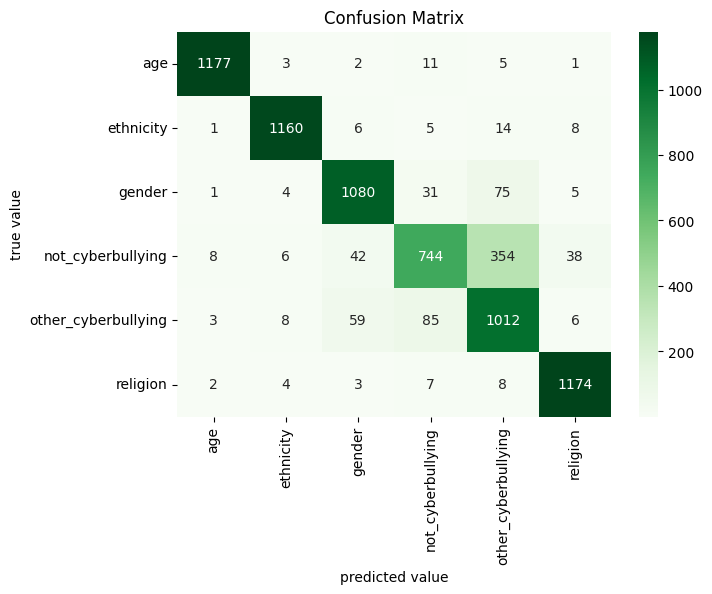

In [ ]:
# Test 2: Model with auxiliary aggression information
print("\n2. Testing with aggression information:")
cyb_test_augmented = prepare_augmented_dataset(cyb_test, has_agg_info=True)
cyb_test_results_aug = make_predictions(model, cyb_test_augmented)
evaluate_dataset(cyb_test_results_aug['label'], cyb_test_results_aug['predictions_cyb'], 'With Aggression Info')


Results for Testing:
Accuracy: 0.862
F1 Score: 0.863

Classification Report:
                     precision    recall  f1-score   support

                age       0.99      0.98      0.98      1199
          ethnicity       0.99      0.97      0.98      1194
             gender       0.92      0.87      0.89      1196
  not_cyberbullying       0.66      0.62      0.64      1192
other_cyberbullying       0.67      0.75      0.71      1173
           religion       0.96      0.97      0.96      1198

           accuracy                           0.86      7152
          macro avg       0.86      0.86      0.86      7152
       weighted avg       0.86      0.86      0.86      7152



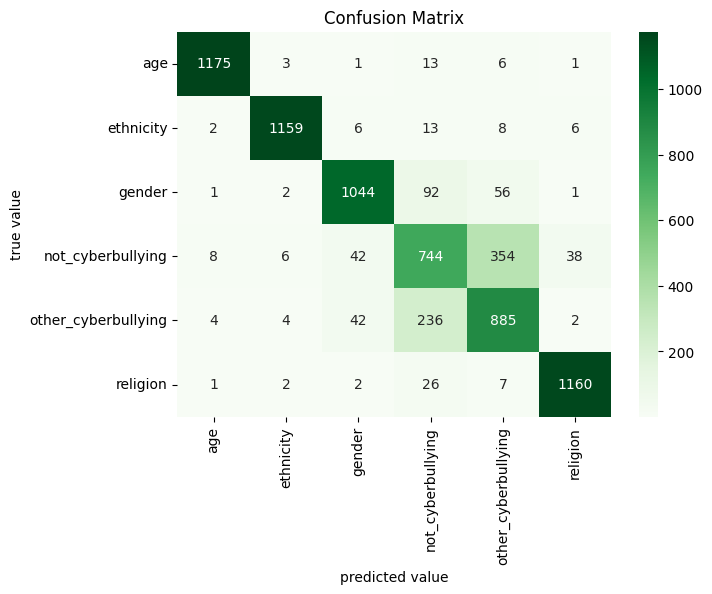

In [ ]:
model_copy=model

cyb_test = make_predictions(model,cyb_test)

evaluate_dataset(cyb_test['label'], cyb_test['predictions_cyb'], 'Testing')

##Generating cyber bullying  label for aggression test dataset for training with auxillary information

In [ ]:
d1_test_ge_2_cyb = make_predictions(model, d1_test)

d1_test_ge_2_cyb['predictions_cyb']=d1_test_ge_2_cyb['predictions_cyb'].map(id2label)

d1_test_ge_2_cyb.to_csv("d1_test_ge_2_cyb.csv", index=False)

from google.colab import files
files.download("d1_test_ge_2_cyb.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
d2_test_ge_2_cyb = make_predictions(model, d2_test)

d2_test_ge_2_cyb['predictions_cyb']=d2_test_ge_2_cyb['predictions_cyb'].map(id2label)

d2_test_ge_2_cyb.to_csv("d2_test_ge_2_cyb.csv", index=False)

from google.colab import files
files.download("d2_test_ge_2_cyb.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
d3_test = d3_test.dropna(subset=['text']).reset_index(drop=True)

In [ ]:
d3_test_ge_2_cyb = make_predictions(model, d3_test)

d3_test_ge_2_cyb['predictions_cyb']=d3_test_ge_2_cyb['predictions_cyb'].map(id2label)

d3_test_ge_2_cyb.to_csv("d3_test_ge_2_cyb.csv", index=False)

from google.colab import files
files.download("d3_test_ge_2_cyb.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
d4_test = d4_test.dropna(subset=['text']).reset_index(drop=True)

In [ ]:
d4_test_ge_2_cyb = make_predictions(model, d4_test)

d4_test_ge_2_cyb['predictions_cyb']=d4_test_ge_2_cyb['predictions_cyb'].map(id2label)

d4_test_ge_2_cyb.to_csv("d4_test_ge_2_cyb.csv", index=False)

from google.colab import files
files.download("d4_test_ge_2_cyb.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
d5_test_ge_2_cyb = make_predictions(model, d5_test)

d5_test_ge_2_cyb['predictions_cyb']=d5_test_ge_2_cyb['predictions_cyb'].map(id2label)

d5_test_ge_2_cyb.to_csv("d5_test_ge_2_cyb.csv", index=False)

from google.colab import files
files.download("d5_test_ge_2_cyb.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>